# Tutorial 4 – Predicting Energies and Nonadiabatic Couplings

In Tutorial 3, we showed how to train a NN model for predicting energies, forces and nonadiabatic couplings.
Here we demonstrate, how to use the trained model, to predict the energies and nonadiabatic couplings for a geometry of the sample molecule, which was not included in the database.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import ase
from ase.db import connect

## Molecule out of Dataset

In the following we create an `Atoms` object from the symbols and positions of our target molecule.

In [2]:
# molecular symbols of target structure (same as database)
symbols = 'CNHHHH'
# positions of atoms in target structure (not included in database)
positions = np.array(
    [[ 0.0000,  0.0000,  0.0000 ],
     [ 2.4321,  0.0000,  0.0000 ],
     [-1.0111,  1.7951,  0.0000 ],
     [ 3.4373,  1.6202, -0.2566 ],
     [ 3.4373, -1.6202,  0.2566 ],
     [-1.0111, -1.7951,  0.0000 ]]
)
# create ase Atoms object
target_mol = ase.Atoms(symbols=symbols, positions=positions)

## Define the calculator

In this step, we define a calculator for predicting for the target geometry the properties. 
Therefore, we have to specify the path to the trained model (see Tutorial 3) as well as the neighbor list for building the representation.


In [3]:
from schnetpack.transform import MatScipyNeighborList
from spainn.interface import NacCalculator

# set up calculator for predictions
calc = NacCalculator(
    model_file=os.path.join(os.getcwd(), 'train', 'best_model_E_F_C'), 
    neighbor_list=MatScipyNeighborList(cutoff=10.0)
)
# apply calculator to target molecule
target_mol.calc = calc

In the next step, we get the predictions from our model, by calling the `get_properties` function for the set of properties, we are interested in (here energies and nonadiabatic couplings).
Note, the `NacCalculator` always returns nonadiabatic couplings $\mathbf{C}_{ij}$ rather than the smoothed nonadiabatic couplings $\mathbf{C}_{ij}^s$ employed in the training. 
Nevertheless, the predictions, need to be requested with the same property key as used in the training.

In [4]:
# predict energies and nacs from NN model
pred = target_mol.get_properties(['energy', 'smooth_nacs'])
pred

{'energy': array([-94.67488565, -94.42807255, -94.33222212]),
 'smooth_nacs': array([[[-5.55834436e-02, -1.67016947e-17, -7.63236560e-19],
         [-1.71284160e-01,  4.90413892e-17, -3.03844639e-19],
         [-9.52767548e-01,  1.31373348e-16,  2.18561979e-17]],
 
        [[-9.73515189e-02, -4.93364229e-17,  2.94756393e-18],
         [-2.03955834e-01,  1.57202331e-18, -3.02399188e-18],
         [ 7.18859946e-01, -4.18493612e-17,  5.87670367e-18]],
 
        [[ 3.81299868e-02, -4.82265658e-02, -1.96809142e-04],
         [-1.94629845e-02,  3.90448386e-02,  1.13046205e-03],
         [ 1.16888676e-01, -9.81919929e-02,  4.69116636e-03]],
 
        [[-3.24237656e-02, -1.53159303e-02,  2.94397172e-03],
         [ 1.06732541e-01,  4.91115399e-02, -8.72029081e-03],
         [ 2.22506380e-02, -3.17968002e-02,  3.09087171e-04]],
 
        [[-3.24237656e-02,  1.53159303e-02, -2.94397172e-03],
         [ 1.06732541e-01, -4.91115399e-02,  8.72029081e-03],
         [ 2.22506380e-02,  3.17968002e-02,

## Mean absolute error for energies

In [5]:
# reference energies from (6,4)-CASSCF/cc-pVDZ calculations
ref = {'energy': np.array([-94.69603647, -94.43388056, -94.40410243])}

mae = np.mean(
    np.abs(np.asarray(pred['energy']).flatten() 
           - np.asarray(ref['energy']).flatten()
          ))

print('MAE: '+str(mae))

MAE: 0.03294638125980498


## Visualization of prediction quality for energies

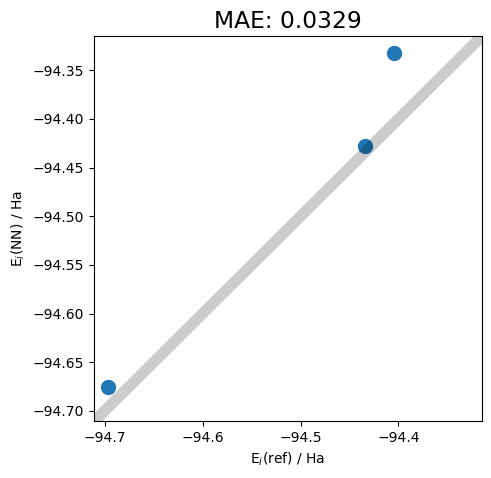

In [6]:
# define plot
plt.figure(figsize=(5, 5))
plt.scatter(ref['energy'], pred['energy'], s=100.0)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["font.size"] = 14

# get limits of axis and aplly same for x and y-axis (square plot)
limits = [*plt.xlim(), *plt.ylim()]
lower_lim = min(limits)
upper_lim = max(limits)
plt.xlim(lower_lim, upper_lim)
plt.ylim(lower_lim, upper_lim)

# plot y=x line to guide eye
plt.plot([lower_lim-2.5, upper_lim+2.5], [lower_lim-2.5, upper_lim+2.5], c='k', alpha=0.2, linewidth=8, linestyle='-')

plt.xlabel('E$_i$(ref) / Ha')
plt.ylabel('E$_i$(NN) / Ha')
plt.title('MAE: '+str(round(mae, 4)))

plt.show()